In [1]:
pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.1 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install umap-learn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp
import torch
import torch.nn.functional as F

In [3]:
from datasets import load_dataset

ds = load_dataset('google-research-datasets/poem_sentiment')

README.md:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.34k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/892 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/105 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/104 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [5]:
train_ds = ds['train']
train_ds

Dataset({
    features: ['id', 'verse_text', 'label'],
    num_rows: 892
})

In [6]:
label_names = ds['train'].features['label'].names
label_names

['negative', 'positive', 'no_impact', 'mixed']

In [7]:
train_ds.column_names

['id', 'verse_text', 'label']

In [8]:
train_ds.features

{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}

In [9]:
train_ds['verse_text'][:2]

['with pale blue berries. in these peaceful shades--',
 'it flows so long as falls the rain,']

In [10]:
train = pd.DataFrame(ds['train'])
train.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


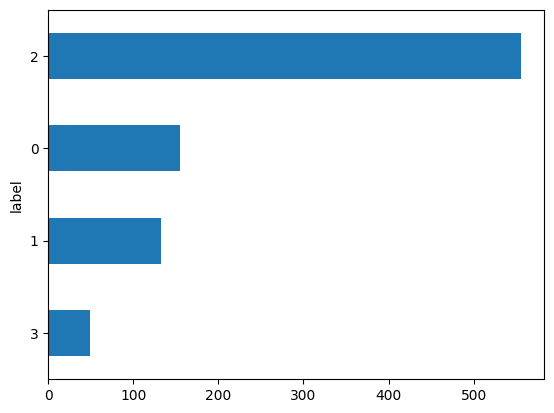

In [11]:
train['label'].value_counts(ascending=True).plot.barh()
plt.show()

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
print('Vocab size: ', tokenizer.vocab_size)
print('Model max length: ', tokenizer.model_max_length)
print('Feature name: ', tokenizer.model_input_names)

Vocab size:  30522
Model max length:  512
Feature name:  ['input_ids', 'attention_mask']


In [14]:
def tokenize(batch):
    return tokenizer(batch['verse_text'], padding=True, truncation=True)

In [15]:
print(tokenize(ds['train'][:2]))

{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


In [26]:
ds_pretrained_features_encoded = ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/892 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

In [27]:
ds_pretrained_features_encoded['train'].column_names

['id', 'verse_text', 'label', 'input_ids', 'attention_mask']

In [28]:
from transformers import AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained('distilbert-base-uncased').to(device)

In [29]:
# Function to extract the hidden states of the [CLS] token from the DistilBERT model
def get_hidden_state(batch):
    # Filter the batch to include only the keys recognized by the tokenizer
    # and move the input tensors to the specified device (e.g., GPU/CPU)
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    
    # Perform inference without computing gradients
    with torch.no_grad():
        # Get the last hidden state from the DistilBERT model
        last_hidden_state = model(**inputs).last_hidden_state
        
    # Extract the hidden state corresponding to the [CLS] token (index 0)
    # Convert it to a NumPy array and return it in a dictionary
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

# Set the format of the dataset to PyTorch tensors for specified columns
ds_pretrained_features_encoded.set_format(
    'torch', columns=["input_ids", "attention_mask", "label"]
)

# Apply the get_hidden_state function to the dataset in batches
pretrained_hidden_states = ds_pretrained_features_encoded.map(
    get_hidden_state, batched=True
)

# Retrieve and print the column names of the train split of the dataset
pretrained_hidden_states['train'].column_names

Map:   0%|          | 0/892 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [30]:
pretrained_hidden_states

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 104
    })
})

In [34]:
X_train = np.array(pretrained_hidden_states['train']['hidden_state'])
y_train = np.array(pretrained_hidden_states['train']['label'])

X_valid = np.array(pretrained_hidden_states['validation']['hidden_state'])
y_valid = np.array(pretrained_hidden_states['validation']['label'])

In [37]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'y_valid shape: {y_valid.shape}')

X_train shape: (892, 768)
y_train shape: (892,)
X_valid shape: (105, 768)
y_valid shape: (105,)


In [44]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_train_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components = 2, metric='cosine').fit(X_train_scaled)

df_embedded_from_hidden = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])

df_embedded_from_hidden['label'] = y_train

display(df_embedded_from_hidden.head())

,X,Y,label
0,12.230720,6.732257,1
1,7.523017,6.572754,2
2,9.292280,4.617175,0
3,6.755717,6.355700,3
4,9.933373,6.365194,3


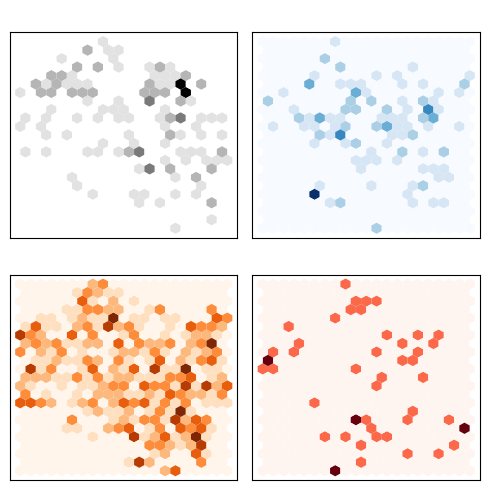

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

axes = axes.flatten()

cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']

labels = ds['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_embedding_subplot = df_embedded_from_hidden.query(f'label == {i}')
    axes[i].hexbin(df_embedding_subplot['X'], df_embedding_subplot['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label, color='white')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [49]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 3000)

lr_clf.fit(X_train, y_train)

print('Logistic Regression score:', lr_clf.score(X_valid, y_valid))

Logistic Regression score: 0.780952380952381


In [50]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)

print('Dummy Classifier score:', dummy_clf.score(X_valid, y_valid))

Dummy Classifier score: 0.6571428571428571


In [51]:
from transformers import AutoModelForSequenceClassification

num_labels = len(ds['train'].features['label'].names)

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels).to(device)

from sklearn.metrics import accuracy_score, f1_score

def compute_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 =f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
from transformers import Trainer, TrainingArguments

# Define the batch size for training and evaluation
batch_size = 12

# Calculate the logging steps (how often logs are generated during training)
logging_steps = len(ds_pretrained_features_encoded['train']) // batch_size

# Specify the name of the model directory for saving outputs
model_name = 'distilbert-base-uncased-finetune-poem'

# Define training arguments
training_args = TrainingArguments(
    output_dir=model_name,                  # Directory to save model and outputs
    num_train_epochs=2,                    # Number of training epochs
    learning_rate=2e-5,                    # Learning rate for optimization
    per_device_train_batch_size=batch_size, # Training batch size per device
    per_device_eval_batch_size=batch_size, # Evaluation batch size per device
    weight_decay=0.01,                     # Weight decay for regularization
    evaluation_strategy='epoch',           # Evaluate at the end of each epoch
    disable_tqdm=False,                    # Enable progress bar
    logging_steps=logging_steps,           # Log metrics every few steps
    push_to_hub=False,                     # Do not push model to Hugging Face Hub
    log_level='error'                      # Set logging level to error
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [55]:
import os
os.environ["WANDB_MODE"] = "disabled"

In [57]:
# Initialize the Trainer for fine-tuning the model
trainer = Trainer(
    model=model,                             # The pre-trained DistilBERT model
    args=training_args,                      # Training arguments (hyperparameters, logging, etc.)
    compute_metrics=compute_metric,          # Function to compute evaluation metrics
    train_dataset=ds_pretrained_features_encoded['train'],  # Training dataset
    eval_dataset=ds_pretrained_features_encoded['validation'],  # Validation dataset
    tokenizer=tokenizer                      # Tokenizer for preprocessing
)

# Start training the model
trainer.train()

/tmp/ipykernel_23/1555901482.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.702961,0.714286,0.646607
2,0.768000,0.589011,0.828571,0.811093


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=76, training_loss=0.7626571467048243, metrics={'train_runtime': 10.6645, 'train_samples_per_second': 167.284, 'train_steps_per_second': 7.126, 'total_flos': 12924311538432.0, 'train_loss': 0.7626571467048243, 'epoch': 2.0})

In [58]:
preds_output = trainer.predict(ds_pretrained_features_encoded['validation'])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [59]:
preds_output.metrics

{'test_loss': 0.5890114307403564,
 'test_accuracy': 0.8285714285714286,
 'test_f1': 0.8110927843278074,
 'test_runtime': 0.2347,
 'test_samples_per_second': 447.443,
 'test_steps_per_second': 21.307}